In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install pyyaml==5.1
!pip install torch==1.8.0+cu101 torchvision==0.9.0+cu101 -f https://download.pytorch.org/whl/torch_stable.html
#install old version of pytorch since detectron2 hasn't released packages for pytorch 1.9

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 274.2/274.2 KB 6.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyyaml: filename=PyYAML-5.1-cp39-cp39-linux_x86_64.whl size=44089 sha256=be17bdaa52044149d02602257b0e00170d93a933cdb9fd890ac7b08ee76663f7
  Stored in directory: /root/.cache/pip/wheels/68/be/8f/b6c454cd264e0b349b47f8ee00755511f277618af9e5dae20d
Successfully built pyyaml
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 6.0
    Uninstalling PyYAML-6.0:
      Successfully uninstalled PyYAML-6.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
dask 2022.12.1 requires pyyaml>=5.3.1, but you have pyyaml 5.1 which is incompatible.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-whee

In [3]:
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.8/index.html
# After this step it will ask you to restart the runtime, please do it.

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.8/index.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.1/6.1 MB 56.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 KB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 KB 6.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 131.0/131.0 KB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 KB 18.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 KB 15.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fvcore: filename=fvcore-0.1.5.post20221221-py3-none-any.whl size=61429 sha256=f547b91baf15c4d952f166a21594cfe8bb49680f126f2d22748f817caa6760a9
  Stored in directory: /root/.cache/pip/wheels/83/42/02/66178d16e5c44dc26d3099318

In [4]:
import torch
assert torch.__version__.startswith("1.8") 
import torchvision
import cv2

###**Register the data to Detectron2 config**

In [5]:
import os
import numpy as np
import json
import random
import matplotlib.pyplot as plt
%matplotlib inline

from detectron2.structures import BoxMode
from detectron2.data import DatasetCatalog, MetadataCatalog

In [6]:
def get_data_dicts(directory, classes):
    dataset_dicts = []
    for filename in [file for file in os.listdir(directory) if file.endswith('.json')]:
        json_file = os.path.join(directory, filename)
        with open(json_file) as f:
            img_anns = json.load(f)

        record = {}
        
        filename = os.path.join(directory, img_anns["imagePath"])
        
        record["file_name"] = filename
        record["height"] = img_anns["imageHeight"]
        record["width"] = img_anns["imageWidth"]
      
        annos = img_anns["shapes"]
        objs = []
        for anno in annos:
            px = [a[0] for a in anno['points']] # x coord
            py = [a[1] for a in anno['points']] # y-coord
            poly = [(x, y) for x, y in zip(px, py)] # poly for segmentation
            poly = [p for x in poly for p in x]

            obj = {
                "bbox": [np.min(px), np.min(py), np.max(px), np.max(py)],
                "bbox_mode": BoxMode.XYXY_ABS,
                "segmentation": [poly],
                "category_id": classes.index(anno['label']),
                "iscrowd": 0
            }
            objs.append(obj)
        record["annotations"] = objs
        dataset_dicts.append(record)
    return dataset_dicts

In [7]:
classes = ['jug','easy_foothold','sloper','large_sloper','easy_edge','crimp_edge','edge_large_sloper','crimp','u_edge','easy_sloper','double_sided_jug','pinch_sloper','foothold','double_sided_sloper','edge','curve_edge_sloper','pocket','pinch','edge_sloper','volume','large_moon_edge','platform']

data_path = '/content/drive/MyDrive/Third Year Project/slab_images/'

DatasetCatalog.clear()
MetadataCatalog.clear()

for d in ["train", "test"]:
    DatasetCatalog.register(
        "category_" + d, 
        lambda d=d: get_data_dicts(data_path+d, classes)
    )
    MetadataCatalog.get("category_" + d).set(thing_classes=classes)

microcontroller_metadata = MetadataCatalog.get("category_train")

###**Training the Detectron2 Instance Segmentation Model**

In [8]:
from detectron2 import model_zoo
from detectron2.engine import DefaultTrainer, DefaultPredictor
from detectron2.config import get_cfg, LazyConfig
from detectron2.utils.visualizer import ColorMode, Visualizer
from detectron2.data import transforms as T
from detectron2.data import build_detection_train_loader, DatasetMapper

###**Inference using a Saved Model**

In [9]:
cfg = get_cfg()
cfg.merge_from_file('/content/drive/MyDrive/Third Year Project/models/model_0_cfg.yaml') # Set config
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5 # Set threshold to return classifications with > 0.5 confidence
cfg.MODEL.WEIGHTS = '/content/drive/MyDrive/Third Year Project/models/model_0.pth' # Set path model .pth
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 22
predictor = DefaultPredictor(cfg)

In [10]:
test_dataset_dicts = get_data_dicts(data_path+'test', classes)
train_dataset_dicts = get_data_dicts(data_path+'train', classes)

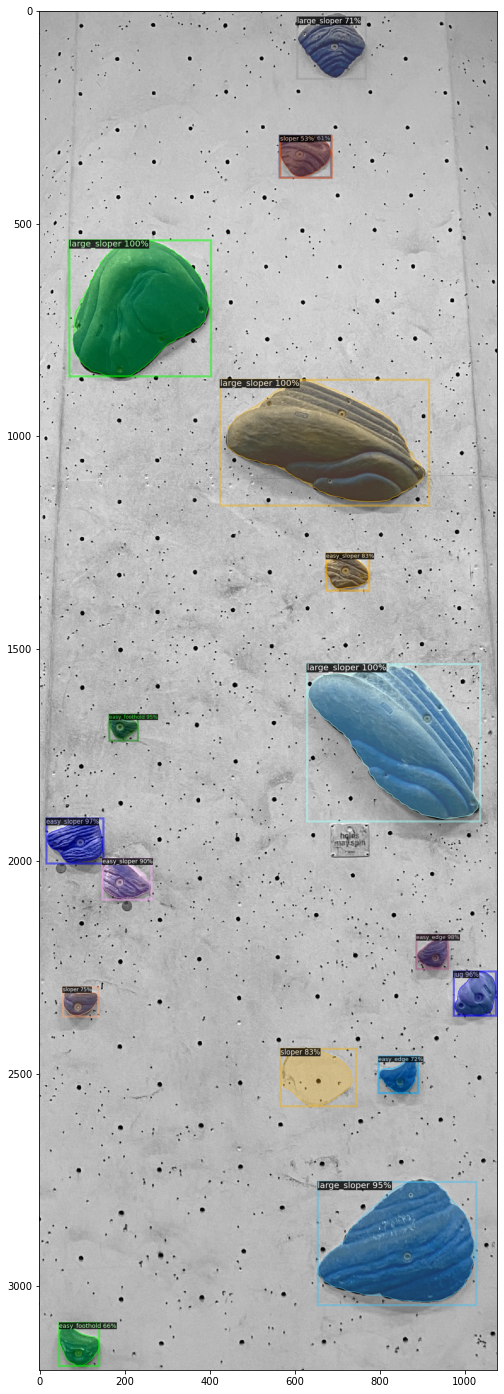

In [11]:
img = cv2.imread('/content/drive/MyDrive/Third Year Project/route_images/blue_V0-V2.jpg')
outputs = predictor(img)
v = Visualizer(img[:, :, ::-1],
                  metadata=microcontroller_metadata, 
                  scale=0.8, 
                  instance_mode=ColorMode.IMAGE_BW # removes the colors of unsegmented pixels
  )
v = v.draw_instance_predictions(outputs["instances"].to("cpu"))

plt.figure(figsize=(25,25))
plt.imshow(cv2.cvtColor(v.get_image()[:, :, ::-1], cv2.COLOR_BGR2RGB))
plt.show()

In [12]:
import cv2
import pickle
import glob
import os

In [23]:
def process_all():
  for file_path in glob.glob("/content/drive/MyDrive/Third Year Project/route_images/*"):
    file_name = os.path.basename(file_path).split(".")[0]
    img = cv2.imread(file_path)
    outputs = predictor(img)
    fields = outputs['instances'].get_fields()
     
    data_out = {'pred_boxes': [],
              'scores': [],
              'pred_classes': [],
              'contours': [],
              'contour_area': []}

    for key in fields.keys():
      for item in fields[key]:
        if key=='pred_masks':
          mask = item.cpu().numpy().astype('uint8')
          contour, _ = cv2.findContours(mask, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
          data_out['contour_area'].append(cv2.contourArea(contour[0]))
          data_out['contours'].append(contour)
        else:
          data_out[key].append(item.cpu().numpy())
        
      with open(f'/content/drive/MyDrive/Third Year Project/tensor_data/{file_name}.pickle', 'wb') as handle:
          pickle.dump(data_out, handle)

process_all()

# fields = outputs['instances'].get_fields()
# print(fields.keys())

# imgcopy = img.copy()
# data_out = {'pred_boxes': [],
#           'scores': [],
#           'pred_classes': [],
#           'contours': [],
#           'contour_area': []}

# for key in fields.keys():
#   for item in fields[key]:
#     if key=='pred_masks':
#       mask = item.cpu().numpy().astype('uint8')
#       contour, _ = cv2.findContours(mask, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
#       data_out['contour_area'].append(cv2.contourArea(contour[0]))
#       data_out['contours'].append(contour)
#     else:
#       data_out[key].append(item.cpu().numpy())

# print(data_out.keys())
# print(data_out['contours'][0])
# cv2.drawContours(imgcopy, data_out['contours'][0], -1, (0,255,0), 3)
# plt.figure(figsize=(25,25))
# plt.imshow(imgcopy)
# with open('/content/drive/MyDrive/Third Year Project/tensor_data/image (100).pickle', 'wb') as handle:
#     pickle.dump(data_out, handle)

# for pred_mask in fields['pred_masks']:
#   # pred_mask is of type torch.Tensor, and the values are boolean (True, False)
#   # Convert it to a 8-bit numpy array, which can then be used to find contours
#   mask = pred_mask.cpu().numpy().astype('uint8')
#   contour, _ = cv2.findContours(mask, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
#   print(cv2.contourArea(contour[0]))

In [ ]:
# open
with open('/content/drive/MyDrive/Third Year Project/tensor_data/image (100).pickle', 'rb') as handle:
  data = pickle.load(handle)
  img_test = img.copy()
  bb = data['pred_boxes'][0]
  cv2.rectangle(img_test, (round(bb[0]), round(bb[1])), (round(bb[2]), round(bb[3])), (255,0,0), 2)
  plt.figure(figsize=(25,25))
  plt.imshow(cv2.cvtColor(img_test, cv2.COLOR_BGR2RGB))
  print(data['pred_classes'][0])
  print(data['contour_area'][0])

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
for d in random.sample(test_dataset_dicts, 2):    
    img = cv2.imread(d["file_name"])
    outputs = predictor(img)
    v = Visualizer(img[:, :, ::-1],
                   metadata=microcontroller_metadata, 
                   scale=0.8, 
                   instance_mode=ColorMode.IMAGE_BW # removes the colors of unsegmented pixels
    )
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))

    plt.figure(figsize=(25,25))
    plt.imshow(cv2.cvtColor(v.get_image()[:, :, ::-1], cv2.COLOR_BGR2RGB))
    plt.show()

Output hidden; open in https://colab.research.google.com to view.